In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import RFE, r_regression, SelectKBest, chi2, f_regression, mutual_info_regression, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, davies_bouldin_score, f1_score, roc_curve, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.utils import resample
from enum import Enum
from kneed import KneeLocator
from collections import defaultdict
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

In [2]:
# Read the Spotify song data from the CSV file
spotify_song_data = pd.read_csv('datasets/Spotify_Dataset_V4.csv')

In [3]:
# restrict to year
spotify_song_data_2022 = spotify_song_data[(spotify_song_data['Date'].str.contains('2022'))]
spotify_song_data_2022.reset_index(drop=True, inplace=True)
spotify_song_data_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107876 entries, 0 to 107875
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              107876 non-null  int64  
 1   Title                             107876 non-null  object 
 2   Artists                           107876 non-null  object 
 3   Date                              107876 non-null  object 
 4   Danceability                      107876 non-null  float64
 5   Energy                            107876 non-null  float64
 6   Loudness                          107876 non-null  float64
 7   Speechiness                       107876 non-null  float64
 8   Acousticness                      107876 non-null  float64
 9   Instrumentalness                  107876 non-null  float64
 10  Valence                           107876 non-null  float64
 11  # of Artist                       107876 non-null  o

## Process average artists score and genre score

In [4]:
song_data = spotify_song_data_2022.copy()
unique_artists = song_data['Artist (Ind.)'].unique()
unique_artists = list(unique_artists)

average_points = song_data.groupby(['id'])['Points (Total)'].mean().reset_index()

average_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

song_data = pd.merge(song_data, average_points, on='id')

unique_songs = song_data.drop_duplicates(subset=['id'], keep='first')

# artists dict to store individual artist's average points
artists_score = defaultdict(float)
for artist in unique_artists:
    artists_score[artist] = song_data[song_data['Artist (Ind.)'] == artist]['Points (Ind for each Artist/Nat)'].mean()
# artist average points
for index, row in unique_songs.iterrows():
    if "Tyler, The Creator" in row['Artists']:
        artists = ['Tyler, The Creator'] + row['Artists'].replace('Tyler, The Creator', '').split(', ')
    else:
        artists = row['Artists'].split(', ')
    
    unique_songs.loc[index, 'Artists_Average_Points'] = sum([artists_score[artist] for artist in artists]) / len(artists)
    # choose the artist with the highest average points and assign to Top_Artist
    unique_songs.loc[index, 'Top_Artist'] = max(artists, key=lambda artist: artists_score.get(artist, 0))


# genres
main_genres = ['pop', 'rock', 'hip hop', 'rap', 'r&b', 'country', 'jazz', 'classical', 'electronic', 'dance', 'latin', 'reggae', 'blues', 'soul', 'funk', 'metal', 'punk', 'folk', 'world', 'indie', 'corrido']

def categorize_genre(sub_genres):
    sub_genres_list = str(sub_genres).lower().split(',')
    for main_genre in main_genres:
        if any(main_genre in sub_genre for sub_genre in sub_genres_list):
            return main_genre
    return 'other'

unique_songs['General_Genre'] = unique_songs['genres'].apply(categorize_genre)

columns_to_keep = ['id', 'Average_Points', 'Artists_Average_Points', 'General_Genre', 'Top_Artist']
print(unique_songs.columns)
unique_songs = unique_songs[columns_to_keep]
unique_songs.reset_index(drop=True, inplace=True)
unique_songs.head(10)

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality',
       'Nationality', 'Continent', 'Points (Total)',
       'Points (Ind for each Artist/Nat)', 'id', 'Song URL', 'genres',
       'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
       'duration_ms', 'Average_Points', 'Artists_Average_Points', 'Top_Artist',
       'General_Genre'],
      dtype='object')


,id,Average_Points,Artists_Average_Points,General_Genre,Top_Artist
0,6BePGk3eCan4FqaW2X8Qy3,54.272727,68.002443,pop,Tate McRae
1,58ge6dfP91o9oXMzq3XkIS,124.443213,85.901304,rock,Arctic Monkeys
2,6HMtHNpW6YPi1hrw9tgF8P,132.969136,130.986159,pop,Lizzo
3,6Hio4nlyWL2WBL8nYlbuGt,21.500000,5.000000,funk,MC K.K
4,0bYg9bo50gSsH3LtXe2SQn,164.573770,143.182927,pop,Mariah Carey
5,7jtQIBanIiJOMS6RyCx6jZ,155.315068,155.315068,pop,Tom Odell
6,4OH5Cd8ZOI1eSgJSC9PYmU,80.592593,40.333333,pop,Mert Demir
7,4fsQ0K37TOXa3hEQfjEic1,105.320000,85.336449,pop,LE SSERAFIM
8,0V3wPSX9ygBnCm8psDIegu,193.958333,103.521596,pop,Taylor Swift
9,4Dvkj6JhhA12EX05fT7y2e,196.699115,125.620669,pop,Harry Styles


## Process consecutive days in rank by each track

In [5]:
# 转换日期格式 e.g. 01/01/2017
# print(song_data[song_data['id'] == '3oZ6dlSfCE9gZ55MGPJctc'])
song_data = spotify_song_data_2022.copy()
song_data['Date'] = pd.to_datetime(song_data['Date'], dayfirst=True)
# 按照歌曲和日期排序
song_data_sorted = song_data.sort_values(by=['id', 'Date'])
# calculate maximum consecutive days of each song
song_data_sorted['date_diff'] = song_data_sorted.groupby(['id'])['Date'].diff().dt.days

song_data_sorted['new_group'] = (song_data_sorted['date_diff'] != 1).cumsum()
song_data_sorted['consecutive_days'] = song_data_sorted.groupby(['id', 'new_group']).cumcount() + 1
max_consecutive_days = song_data_sorted.groupby(['id'])['consecutive_days'].max().reset_index()
max_consecutive_days.rename(columns={'consecutive_days': 'max_consecutive_days'}, inplace=True)

In [6]:
retention_record = song_data_sorted.merge(max_consecutive_days, on='id', how='left')
# merge unique songs
retention_record.drop(['consecutive_days', 'date_diff', 'new_group', '# of Artist', 'Artist (Ind.)', '# of Nationality', 'Nationality', 'Points (Total)', 'Points (Ind for each Artist/Nat)', 'Song URL', 'genres'], axis=1, inplace=True)
retention_record = retention_record.drop_duplicates(subset='id')
retention_record.reset_index(drop=True, inplace=True)
# merge unique songs
retention_record = pd.merge(retention_record, unique_songs, on='id')
retention_record.columns

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Continent', 'id', 'popularity', 'key', 'liveness', 'mode',
       'tempo', 'time_signature', 'duration_ms', 'max_consecutive_days',
       'Average_Points', 'Artists_Average_Points', 'General_Genre',
       'Top_Artist'],
      dtype='object')

In [7]:
# Plot a horizontal bar chart
def plot_top_songs_consecutive_days(n: int, df: pd.DataFrame):
    df = df.sort_values(by='max_consecutive_days', ascending=False).head(n)
    plt.figure(figsize=(10, 20))
    plt.barh(df['Title'] + " by " + df['Artists'], df['max_consecutive_days'], color='skyblue')
    plt.xlabel('Maximum Consecutive Days')
    plt.ylabel('Songs')
    plt.title('Top ' + str(n) + ' Songs with Longest Consecutive Days on Spotify Top 200 Chart')
    plt.gca().invert_yaxis()  # To improve readability, place songs with the longest consecutive days at the top
    plt.show()

def plot_distribution(df: pd.DataFrame, bins: int = 1):
    # plot distribution plots with each bar of size 10
    plt.figure(figsize=(10, 10))
    sns.distplot(df, bins=bins, kde=False, color='skyblue')
    plt.xlabel('Maximum Consecutive Days')
    plt.ylabel('Density')
    plt.title('Distribution of Maximum Consecutive Days')
    plt.show()


# max_consecutive_days_count = retention_record.groupby(['max_consecutive_days']).size().reset_index(name='count')

# hit songs last for more than 1 week
retention_record['is_hit'] = retention_record['max_consecutive_days'].apply(lambda x: 1 if x >= 7 else 0)

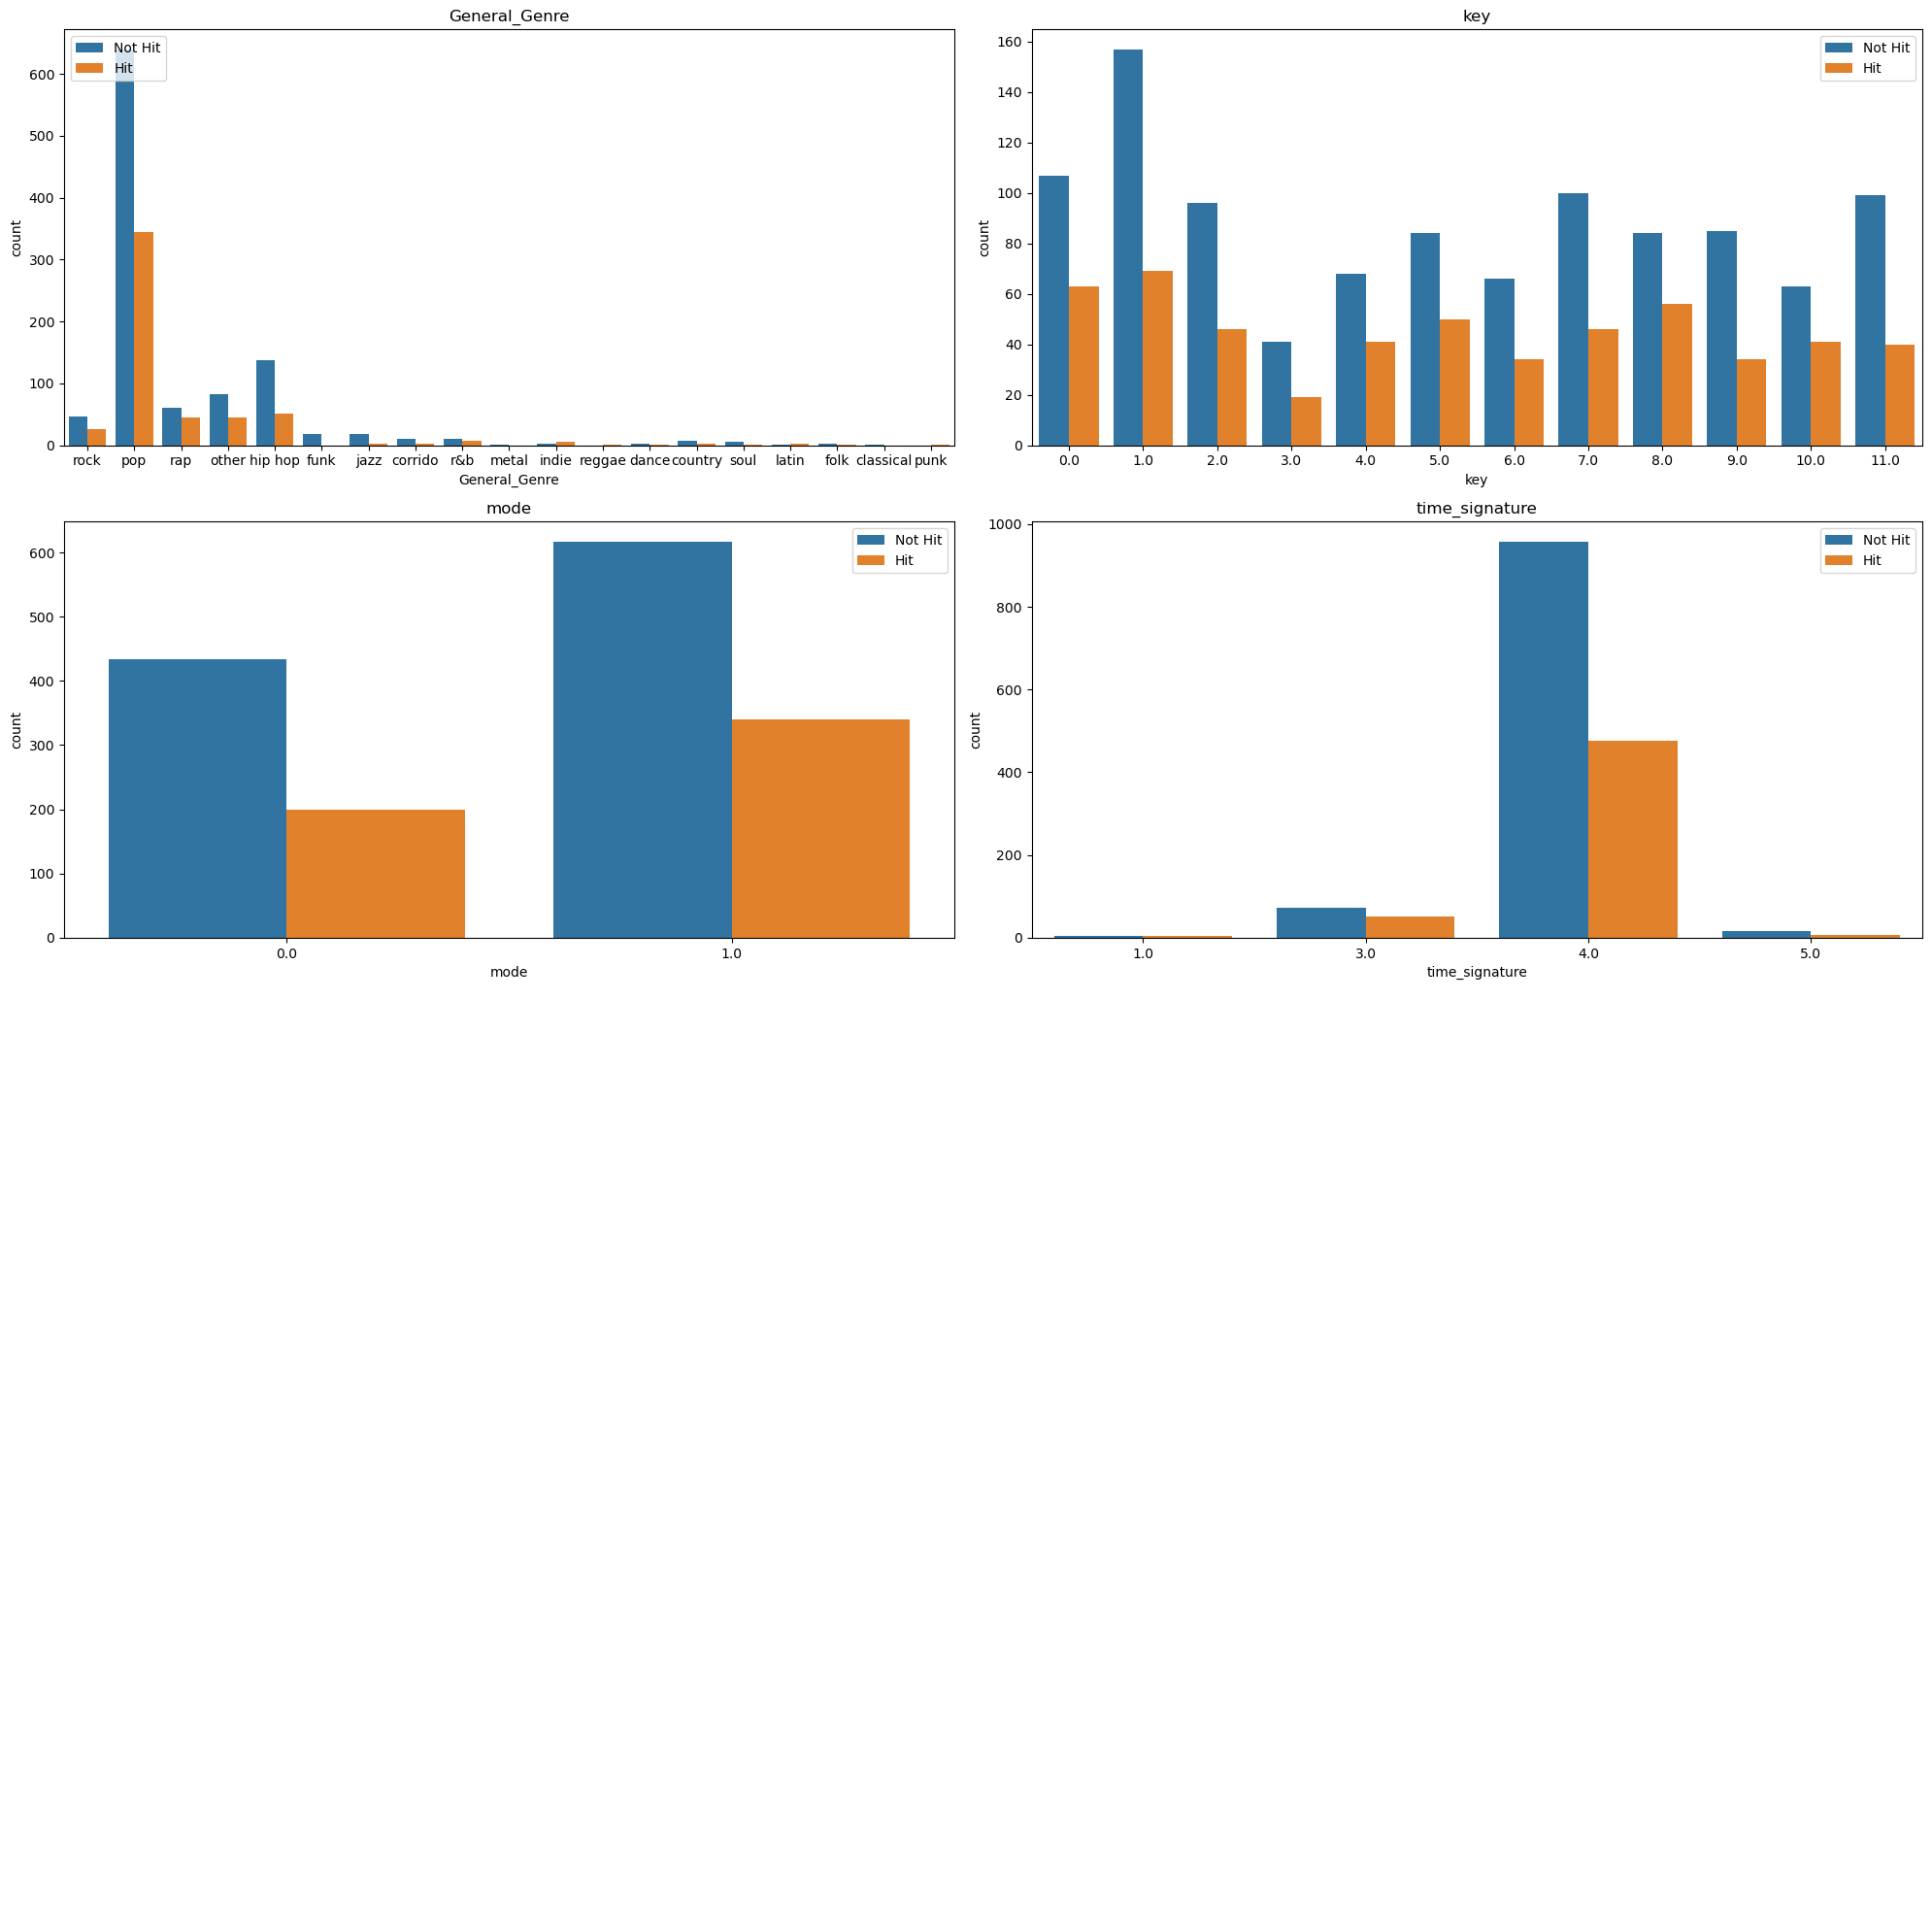

In [8]:
# categorical variables to plot with hit songs
def plot_categorical_graph(df: pd.DataFrame, columns: list):
    # plot the categorical variables against is_hit
    fig, axes = plt.subplots(4, len(columns) // 4 + 1, figsize=(20, 20))
    for i, axes in enumerate(axes.flatten()):
        if i < len(columns):
            sns.countplot(x=columns[i], hue='is_hit', data=df, ax=axes)
            axes.set_title(columns[i])
            axes.legend(['Not Hit', 'Hit'])
        else:
            axes.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_categorical_graph(retention_record, ['General_Genre', 'key', 'mode', 'time_signature'])
    

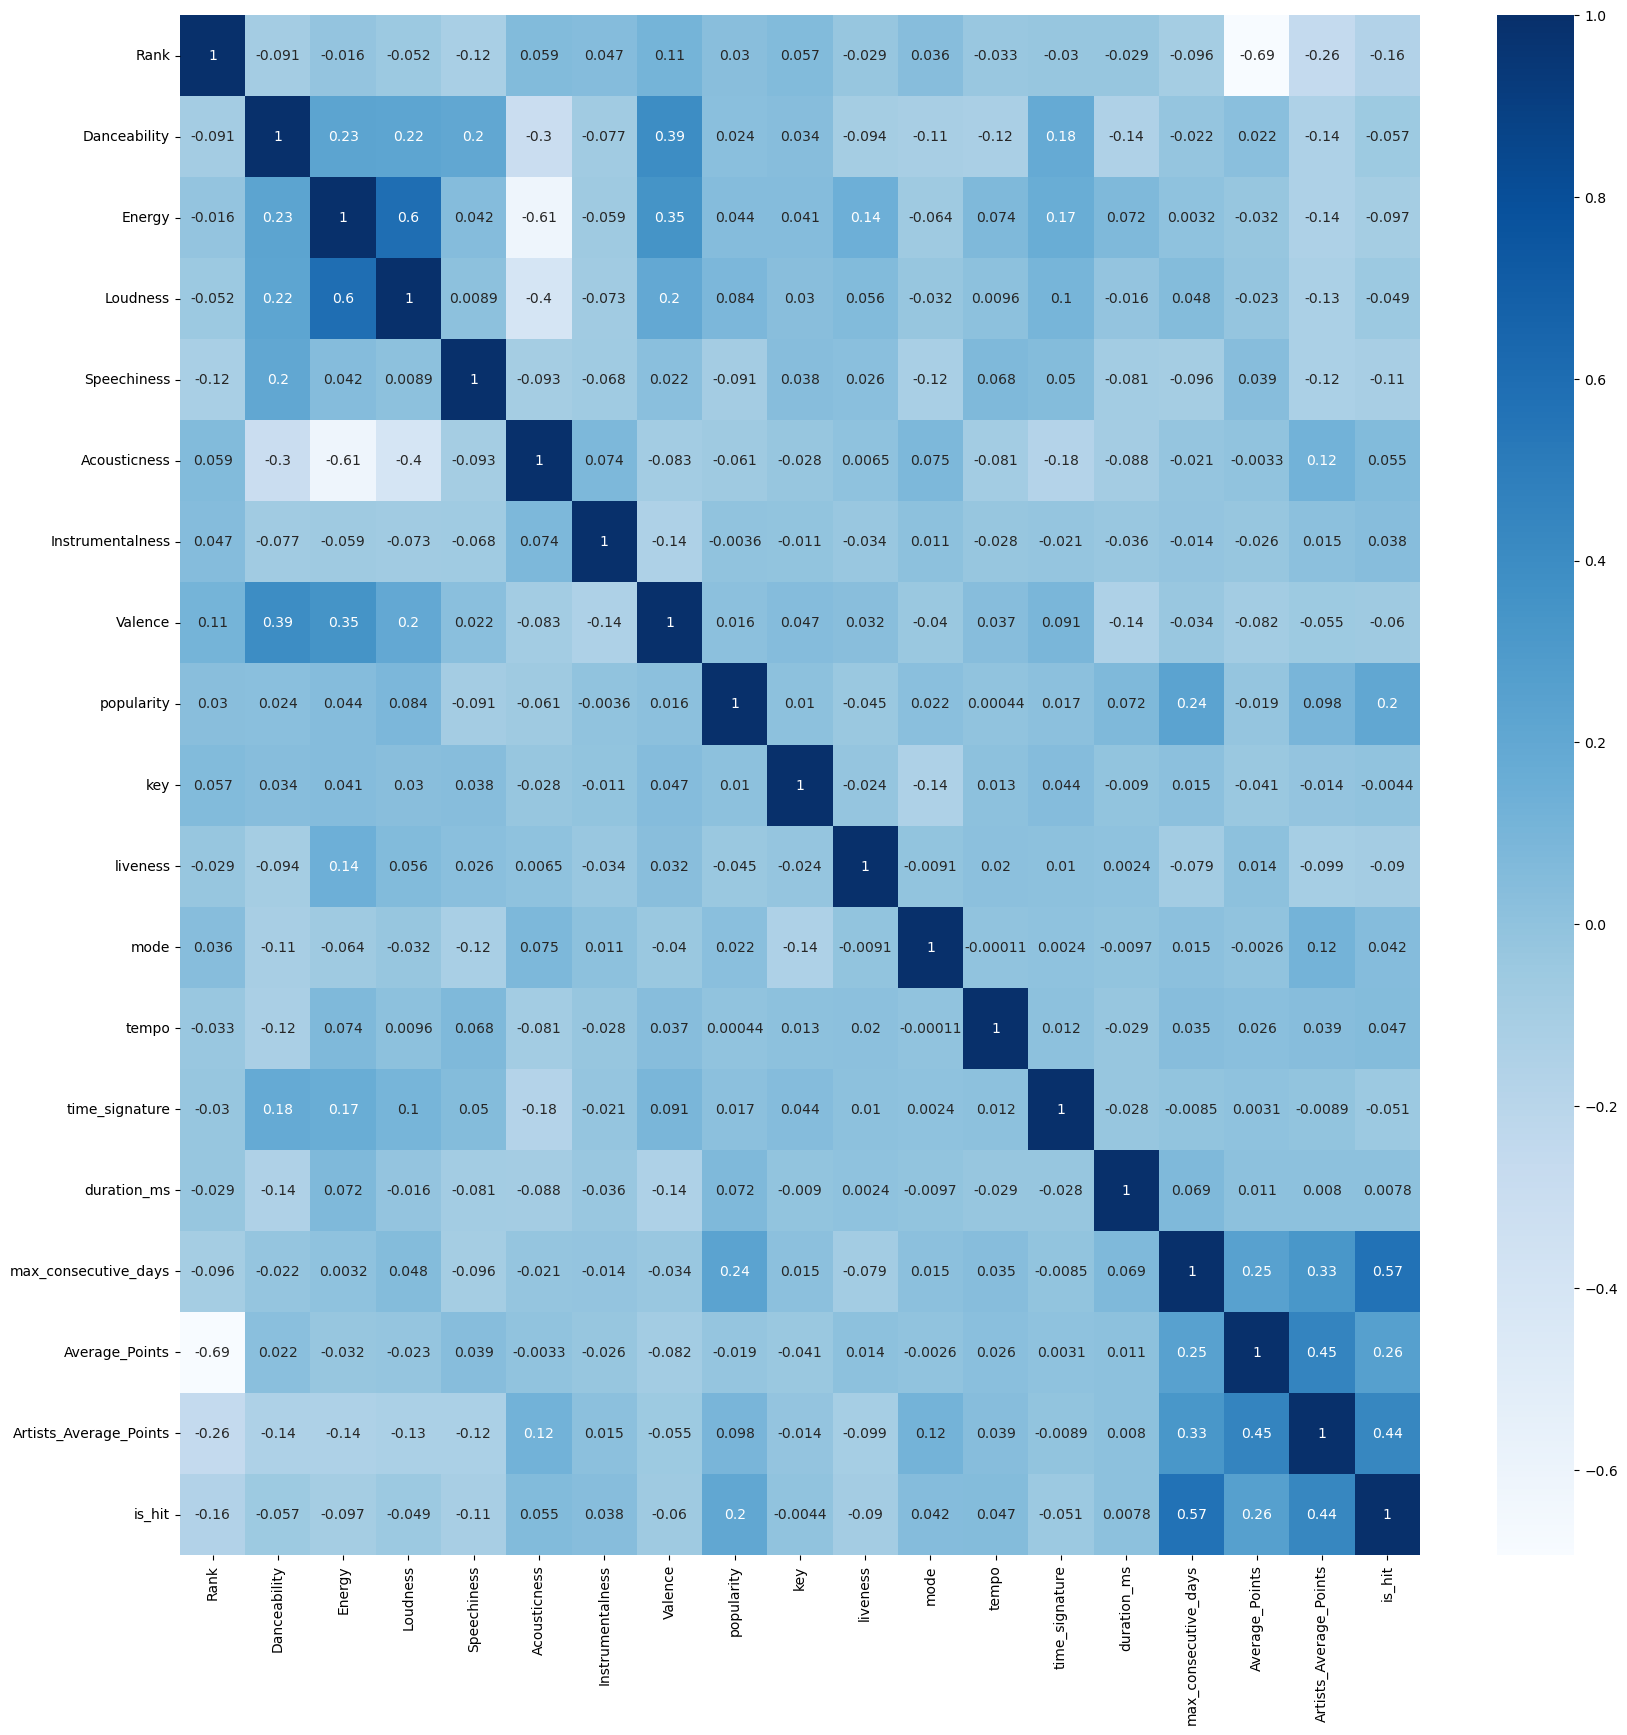

In [9]:
def plot_corr_heatmap(df: pd.DataFrame):
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.corr(method='pearson'), annot=True, cmap='Blues')
    plt.show()

plot_corr_heatmap(retention_record)

## Ready for PCA

In [10]:
def remove_outliers(df: pd.DataFrame, columns: list, threshold: float):
   
    
    print("Before removing outliers: ", df.shape)
    for column in columns:
        # check if the type of each column is numeric
        if df[column].dtype not in ['int64', 'float64']:
            continue
        df = df[np.abs(df[column] - df[column].mean()) <= (threshold * df[column].std())]
        
    print("After removing outliers: ", df.shape)
    return df

# print("Before removing outliers: ", retention_record.shape)
# cleaned_retention_record = remove_outliers(retention_record, ['max_consecutive_days'], 3)
# cleaned_retention_record.reset_index(drop=True, inplace=True)
# print("After removing outliers: ", cleaned_retention_record.shape)
cleaned_retention_record = retention_record.copy()

In [31]:
song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

Knee Point: 3
Cumulative percent variance explained: [0.9999999842164987, 0.9999999910405963, 0.9999999962818625, 0.9999999980973864, 0.9999999991318328, 1.0]


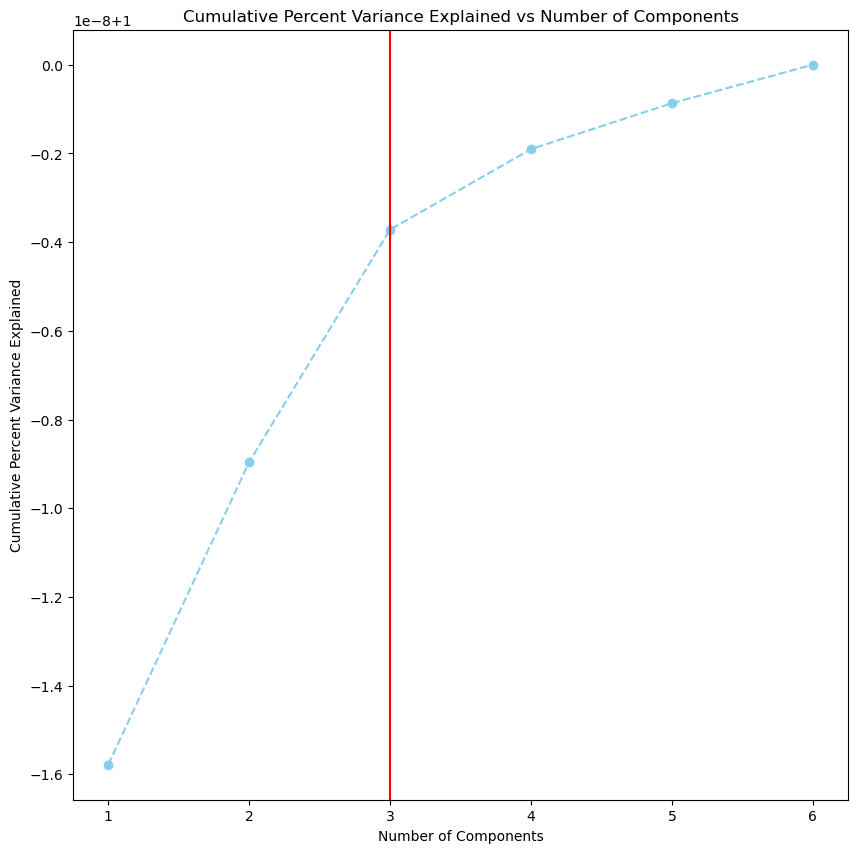

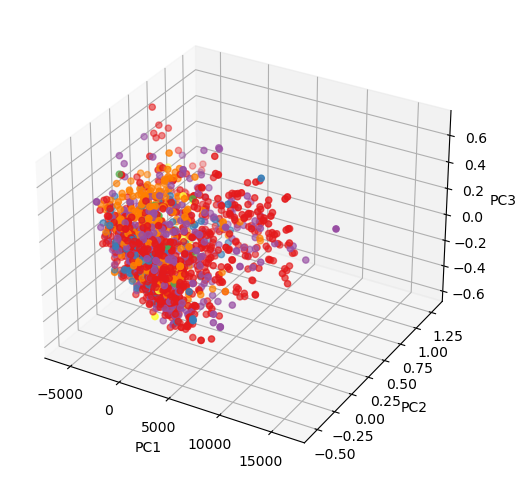

(1589, 29)


In [39]:
# pca
def pca(data: pd.DataFrame, target_columns: list = song_attributes, n_components: int = 2):
    pca = PCA(n_components=n_components)

    pca_data = pca.fit_transform(data[target_columns])

    pca_data = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, n_components+1)])
    return pca_data
    
def get_knee_n(data: pd.DataFrame, target_columns: list = song_attributes):
    number_of_components = len(target_columns)
    # cumulative percent variance explained
    cumulative_percent_variance_explained = []
    
    for i in range(1, number_of_components+1):
        pca = PCA(n_components=i)
        pca.fit_transform(data[target_columns])
        cumulative_percent_variance_explained.append(np.sum(pca.explained_variance_ratio_))
    
    kn = KneeLocator(range(1, number_of_components+1), cumulative_percent_variance_explained, curve='concave', direction='increasing')
    print(f'Knee Point: {kn.knee}')
    print(f'Cumulative percent variance explained: {cumulative_percent_variance_explained}')
    
    # plot the explained variance ratio vs number of components
    plt.figure(figsize=(10, 10))
    plt.plot(range(1, number_of_components+1), cumulative_percent_variance_explained, marker='o', linestyle='--', color='skyblue')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Percent Variance Explained')
    plt.title('Cumulative Percent Variance Explained vs Number of Components')
    plt.axvline(x=kn.knee, color='red')
    plt.show()
    
    return kn.knee

def plot_pca_graph(pca_data: pd.DataFrame, data: pd.DataFrame, label_column: str = 'Continent', n_components: int = 2):
    # plot 3d scatter plot
    if n_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # map the continent into colors
        color_map = ListedColormap(plt.cm.Set1.colors[:len(data[label_column].unique())])
        ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], c=data[label_column].map({continent: i for i, continent in enumerate(data[label_column].unique())}), cmap=color_map)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
        
n = get_knee_n(cleaned_retention_record, song_attributes)
pca_data = pca(cleaned_retention_record, song_attributes, n_components=n)
plot_pca_graph(pca_data, cleaned_retention_record, n_components=n)
pca_retention_record = pd.concat([cleaned_retention_record, pca_data], axis=1)
# drop the original attributes
# pca_retention_record.drop(song_attributes, axis=1, inplace=True)
print(pca_retention_record.shape)

In [57]:
for column in pca_retention_record.columns:
    # check if Dtype is object
    if pca_retention_record[column].dtype == 'object':
        # convert the column into categorical
        pca_retention_record[column] = pca_retention_record[column].astype('category')
        # convert the categorical column into codes
        pca_retention_record[column] = pca_retention_record[column].cat.codes

## Feature extraction

In [58]:
# feature selection for the target column max_consecutive_days

X = pca_retention_record.drop(['max_consecutive_days', 'Date', 'id', 'Title', 'Average_Points', 'Artists', 'popularity'], axis=1)
y = pca_retention_record['max_consecutive_days']

# mutual information
def get_mutual_information_scores(X: pd.DataFrame, y: pd.DataFrame):
    mutual_information_scores = mutual_info_regression(X, y)
    mutual_information_scores = pd.Series(mutual_information_scores, name='Mutual Information Scores', index=X.columns)
    mutual_information_scores = mutual_information_scores.sort_values(ascending=False)
    return mutual_information_scores

mutual_information_scores = get_mutual_information_scores(X, y)
print(mutual_information_scores)


is_hit                    0.642819
Artists_Average_Points    0.325563
Top_Artist                0.212602
Rank                      0.089514
Energy                    0.071656
Continent                 0.044308
liveness                  0.044159
duration_ms               0.035813
PC2                       0.034783
Speechiness               0.028740
Loudness                  0.025640
PC1                       0.025386
Instrumentalness          0.019225
PC3                       0.019034
time_signature            0.017862
General_Genre             0.014597
tempo                     0.011662
Valence                   0.011544
Acousticness              0.001889
Danceability              0.000000
key                       0.000000
mode                      0.000000
Name: Mutual Information Scores, dtype: float64


In [62]:
# feature selection for the target column is_hit
categorical_features = ['Continent', 'Top_Artist']
one_hot_columns = ['General_Genre', 'time_signature']

all_features = pca_retention_record.columns.difference(['is_hit', 'max_consecutive_days', 'Date', 'id', 'Title', 'Average_Points', 'Artists', 'Rank', 'PC1', 'PC2', 'PC3'])
# one-hot encoding for categorical features

rfr = RandomForestRegressor()
print('-'*20 + 'all features' + '-'*20)
X = pca_retention_record[all_features]
y = pca_retention_record['is_hit']
X = pd.get_dummies(X, columns=one_hot_columns)

le = LabelEncoder()
X[categorical_features] = X[categorical_features].apply(le.fit_transform)

rfr.fit(X, y)
feature_importances = pd.Series(rfr.feature_importances_, name='Feature Importances', index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

--------------------all features--------------------
Artists_Average_Points    0.263704
popularity                0.162137
duration_ms               0.066565
Danceability              0.052751
Valence                   0.050679
tempo                     0.048977
Speechiness               0.048614
Acousticness              0.048082
liveness                  0.044892
Energy                    0.043976
Top_Artist                0.043044
Loudness                  0.041055
key                       0.020534
Instrumentalness          0.017388
Continent                 0.014543
General_Genre_12          0.004995
mode                      0.004380
General_Genre_6           0.004325
General_Genre_15          0.004197
General_Genre_11          0.002930
General_Genre_14          0.002359
time_signature_3.0        0.001956
General_Genre_17          0.001392
time_signature_1.0        0.001179
time_signature_4.0        0.001014
General_Genre_3           0.000802
General_Genre_1           0.000779
Ge

In [35]:
target_column = 'is_hit'
# selected_feature_columns = ["Artists_Average_Points", "PC1", "PC2", "PC3",  "duration_ms", "liveness", "tempo"]
selected_feature_columns = ["Artists_Average_Points", "Danceability", "liveness", "Valence", "Energy", "Speechiness", "Loudness", "Acousticness", "duration_ms", "liveness", "tempo"]

def get_X_y(df: pd.DataFrame, target_column: str, selected_feature_columns: list, categorical_features: list, one_hot_columns: list, downsample: bool = False, outliers: bool = True):
    if not outliers:
        df = remove_outliers(df, selected_feature_columns, 3)
    
    if categorical_features:
        le = LabelEncoder()
        df[categorical_features] = df[categorical_features].apply(le.fit_transform)
    
    if downsample:
        num_hit_songs = len(df[df[target_column] == 1])
        num_non_hit_songs = len(df[df[target_column] == 0])
        majority_class = df[df[target_column] == 0] if num_non_hit_songs > num_hit_songs else df[df[target_column] == 1]
        minority_class = df[df[target_column] == 1] if num_non_hit_songs > num_hit_songs else df[df[target_column] == 0]
        # downsample the majority class
        majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
        # combine the minority class with downsampled majority class
        downsampled_data = pd.concat([majority_downsampled, minority_class])
        X = downsampled_data[selected_feature_columns]
        y = downsampled_data[target_column]
        return X, y
    else:
        X = df[selected_feature_columns]
        y = df[target_column]
    return X, y
X, y = get_X_y(pca_retention_record, target_column, selected_feature_columns, [] , downsample=False, outliers=False)

Before removing outliers:  (1589, 29)
After removing outliers:  (1567, 29)


In [36]:
# logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
# standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# normalize the data
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

logistic_regression = LogisticRegression(class_weight='balanced')
logistic_regression.fit(X_train, y_train)
print('-'*20 + 'logistic regression' + '-'*20)
y_pred = logistic_regression.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# decision tree
print('-'*20 + 'decision tree' + '-'*20)
decision_tree = RandomForestClassifier(class_weight='balanced')
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# random forest
print('-'*20 + 'random forest' + '-'*20)
random_forest = RandomForestClassifier(class_weight='balanced')
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# svm
print('-'*20 + 'svm' + '-'*20)
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# naive bayes
print('-'*20 + 'naive bayes' + '-'*20)
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# KNN classifier
print('-'*20 + 'KNN classifier' + '-'*20)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


--------------------logistic regression--------------------
Accuracy Score:  0.7197452229299363
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       218
           1       0.53      0.67      0.59        96

    accuracy                           0.72       314
   macro avg       0.68      0.70      0.69       314
weighted avg       0.74      0.72      0.73       314

--------------------decision tree--------------------
Accuracy Score:  0.7898089171974523
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       218
           1       0.70      0.55      0.62        96

    accuracy                           0.79       314
   macro avg       0.76      0.72      0.74       314
weighted avg       0.78      0.79      0.78       314

--------------------random forest--------------------
Accuracy Score:  0.7898089171974523
              precision    recall  f1-score   support

           0   

In [ ]:
## neural network : MLP
grid = {
    'hidden_layer_sizes': [(256), (512)],
    'batch_size': [16, 32],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'max_iter': [1000],
    'shuffle': [True],
    'tol': [0.0001],
    'learning_rate': ['constant'],
}

mlp = MLPClassifier(random_state=42)
mlp_grid = GridSearchCV(mlp, grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid.fit(X_train, y_train)
best_mlp = mlp_grid.best_estimator_
# print the best hyperparameters
print('Best Hyperparameters: \n', mlp_grid.best_params_)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# print confusion matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))


In [ ]:
# linear regression
selected_features = ['Artists_Average_Points', 'Rank', 'Continent', 'duration_ms', 'General_Genre', 'tempo', 'liveness', 'PC1', 'PC2', 'PC3']
 
categorical_features = ['Continent', 'General_Genre']
numerical_features = list(set(selected_features) - set(categorical_features))

X = pca_retention_record[selected_features]
y = pca_retention_record['max_consecutive_days']

# label encoding
for feature in list( set(X.columns) & set(categorical_features) ):
    X[feature] = X[feature].astype('category')
    X[feature] = X[feature].cat.codes

# standardize the data
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.__class__.__name__)
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))


# print the first 10 predictions
print(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10))
